In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from transformers import XLMRobertaTokenizer, XLMRobertaModel, AdamW, TrainingArguments, Trainer, EarlyStoppingCallback, TrainerCallback
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score, f1_score
import numpy as np
import ast
from sklearn.model_selection import StratifiedKFold

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/training-model/labeled_31k.csv


In [89]:
labeled_df = pd.read_csv("/kaggle/input/training-model/labeled_31k.csv")
# labeled_df = labeled_df.sample(n=2000, random_state=42)

In [90]:
labeled_df.fillna('none', inplace=True)
labeled_df.rename(columns={'S': 'sentiment', 'C': 'candidate_mention', 'T': 'topic'}, inplace=True)

In [91]:
import ast

def normalize_mentions(mentions):
    mentions_list = ast.literal_eval(mentions)
    if mentions_list == [4]:
        return [0, 0, 0, 0]  # Return a list of zeros for no candidate
    mentions_list = [m for m in mentions_list if m != 4] 
    encoded_vector = [0] * 4  # Create a list of zeros
    for candidate_id in mentions_list:
        encoded_vector[candidate_id] = 1
    return encoded_vector

# Apply the function to the DataFrame
candidate_mentions = labeled_df['candidate_mention'].apply(normalize_mentions).tolist()
labeled_df[['None', 'Candidate 1', 'Candidate 2', 'Candidate 3']] = pd.DataFrame(candidate_mentions, index=labeled_df.index)

labeled_df.head

<bound method NDFrame.head of            id                                            content  sentiment  \
0           0            Heran, masih ada yang melabeli diri ...          1   
1           1  Dukungan penuh Ganjar Pranowo pada kebijakan k...          2   
2           2                                     Jujur amat sih          4   
3           3  Alhamdulillah saya baru saja sadar, ternyata p...          1   
4           4   Yakin sekali, MasBOWOGBran PilihanKITA mampu ...          2   
...       ...                                                ...        ...   
31666  106316  Bayangkan jika kedua kubu bertemu, kubu 02 aka...          4   
31667  106317       Banyak pendukung Anies yang sangat antusias.          2   
31668  106318  Prabowo, sebagai pilar utama, memberikan kekua...          2   
31669  106319  Para pendamping desa dipaksa untuk mempromosik...          1   
31670  106320  Politik identitas Anies Baswedan hanya mencipt...          1   

      candidate_menti

In [92]:
# Initialize the tokenizer
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')

# Encode labels
label_encoders = {}
for column in ['candidate_mention', 'sentiment', 'topic']:
    le = LabelEncoder()
    labeled_df[column] = le.fit_transform(labeled_df[column])
    label_encoders[column] = le

In [93]:
from sklearn.model_selection import train_test_split

# Split the data
train_df, val_df = train_test_split(labeled_df, test_size=0.2, stratify=labeled_df['topic'], random_state=42)

print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}")

Train size: 25336, Validation size: 6335


In [94]:
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=512):
        self.texts = df['content'].tolist()
        self.candidate_mentions = df[['None', 'Candidate 1', 'Candidate 2', 'Candidate 3']].values.tolist()
        self.sentiments = df['sentiment'].values.tolist()
        self.topics = df['topic'].values.tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        candidate_mention = self.candidate_mentions[idx]
        sentiment = self.sentiments[idx]
        topic = self.topics[idx]
        encoding = self.tokenizer(
            text, 
            padding='max_length', 
            truncation=True,
            max_length=self.max_length, 
            return_tensors='pt'
        )
        labels = torch.cat((
            torch.tensor(candidate_mention, dtype=torch.float),  # Multi-label (float)
            torch.tensor([sentiment], dtype=torch.long),        # Single-label (long)
            torch.tensor([topic], dtype=torch.long)             # Single-label (long)
        ))

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': labels 
        }

# Create datasets
train_dataset = CustomDataset(train_df, tokenizer)
val_dataset = CustomDataset(val_df, tokenizer)

In [95]:
from torch.utils.data import DataLoader

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [96]:
import torch.nn as nn
from transformers import XLMRobertaModel

class MultiTaskXLMRoberta(nn.Module):
    def __init__(self):
        super(MultiTaskXLMRoberta, self).__init__()
        self.roberta = XLMRobertaModel.from_pretrained('xlm-roberta-base')
        self.classifier_candidate = nn.Linear(self.roberta.config.hidden_size, 4)
        self.classifier_sentiment = nn.Linear(self.roberta.config.hidden_size, len(label_encoders['sentiment'].classes_))
        self.classifier_topic = nn.Linear(self.roberta.config.hidden_size, len(label_encoders['topic'].classes_))
        
        self.criterion_candidate = nn.BCEWithLogitsLoss()
        self.criterion_sentiment = nn.CrossEntropyLoss()
        self.criterion_topic = nn.CrossEntropyLoss() 

    def forward(self, input_ids, attention_mask=None, labels=None):
        if attention_mask is None:
            attention_mask = torch.ones(input_ids.size(), dtype=torch.bool, device=input_ids.device)
        
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs[0][:, 0, :]

        candidate_logits = self.classifier_candidate(cls_output)
        sentiment_logits = self.classifier_sentiment(cls_output)
        topic_logits = self.classifier_topic(cls_output)
        
        if labels is not None:
            # Calculate loss only during training
            loss_candidate = self.criterion_candidate(candidate_logits, labels[:, :4].float())
            loss_sentiment = self.criterion_sentiment(sentiment_logits, labels[:, 4].long())
            loss_topic = self.criterion_topic(topic_logits, labels[:, 5].long()) * 1.5

            total_loss = loss_candidate + loss_sentiment + loss_topic
            return {
                "loss": total_loss,  # Return the combined loss
                "candidate_logits": candidate_logits,
                "sentiment_logits": sentiment_logits,
                "topic_logits": topic_logits
            }
        else:
            # Return predictions during inference
            return {
                "candidate_logits": candidate_logits,
                "sentiment_logits": sentiment_logits,
                "topic_logits": topic_logits
            }

In [97]:
# move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [98]:
def compute_metrics(pred):
    labels = pred.label_ids
    candidate_threshold = 0.5
    
    # Extract predictions for EACH TASK
    candidate_preds = pred.predictions[0]
    sentiment_preds = pred.predictions[1]
    topic_preds = pred.predictions[2]

    # Candidate Mention (apply sigmoid and threshold to each element)
    candidate_probs = torch.sigmoid(torch.tensor(candidate_preds)) # Get probabilities
    candidate_preds = (candidate_probs > candidate_threshold).int() # Apply threshold

    # Calculate F1 score for each candidate separately 
    candidate_f1_scores = []
    candidate_confusion_matrices = []
    for i in range(4):
        candidate_f1_scores.append(
            f1_score(labels[:, i], candidate_preds[:, i], average='binary')
        )
        candidate_confusion_matrices.append(
            confusion_matrix(labels[:, i], candidate_preds[:, i]).tolist()
        )

    # You can average the individual F1 scores if needed
    average_candidate_f1 = np.mean(candidate_f1_scores) 

    # Sentiment
    sentiment_preds = np.argmax(sentiment_preds, axis=1)
    sentiment_accuracy = accuracy_score(labels[:, 4], sentiment_preds)
    sentiment_confusion_matrix = confusion_matrix(labels[:, 4], sentiment_preds).tolist()

    # Topic
    topic_preds = np.argmax(topic_preds, axis=1)
    topic_accuracy = accuracy_score(labels[:, 5], topic_preds)
    topic_confusion_matrix = confusion_matrix(labels[:, 5], topic_preds).tolist()
    
    return {
        "candidate_f1": average_candidate_f1,
        "sentiment_accuracy": sentiment_accuracy,
        "topic_accuracy": topic_accuracy,
        "candidate_confusion_matrices": candidate_confusion_matrices,
        "sentiment_confusion_matrix": sentiment_confusion_matrix,
        "topic_confusion_matrix": topic_confusion_matrix
    }

class ConfusionMatrixCallback(TrainerCallback):
    def __init__(self, trainer):
        super().__init__()
        self.trainer = trainer

    def on_epoch_end(self, args, state, control, **kwargs):
        if control.should_evaluate:
            eval_results = self.trainer.evaluate()

            fig, axes = plt.subplots(2, 3, figsize=(18, 8))

            candidate_confusion_matrices = eval_results['eval_candidate_confusion_matrices']
            sentiment_confusion_matrix = eval_results['eval_sentiment_confusion_matrix']
            topic_confusion_matrix = eval_results['eval_topic_confusion_matrix']
            
            for i, confusion_mat in enumerate(candidate_confusion_matrices):                
                row = i // 3  # Calculate row index
                col = i % 3  # Calculate column index

                sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", ax=axes[row, col])
                axes[row, col].set_xlabel("Predicted Label")
                axes[row, col].set_ylabel("True Label")
                axes[row, col].set_title(f"Candidate {i + 1} Confusion Matrix")  

                # Correct way to set ticks:
                axes[row, col].set_xticks(list(range(len(confusion_mat[0]))))  
                axes[row, col].set_yticks(list(range(len(confusion_mat))))  

                # Simplified labels (0, 1, 2, 3, 4) 
                axes[row, col].set_xticklabels([str(i) for i in range(len(confusion_mat[0]))])
                axes[row, col].set_yticklabels([str(i) for i in range(len(confusion_mat))])

                axes[row, col].set_xticklabels(axes[row, col].get_xticklabels(), rotation=0)
                axes[row, col].set_yticklabels(axes[row, col].get_yticklabels(), rotation=0)

            # Sentiment Heatmap
            sns.heatmap(sentiment_confusion_matrix, annot=True, fmt="d", cmap="Blues", ax=axes[1, 2])  
            axes[1, 2].set_xlabel("Predicted Label")
            axes[1, 2].set_ylabel("True Label")
            axes[1, 2].set_title("Sentiment Confusion Matrix")
            axes[1, 2].set_xticks(list(range(len(sentiment_confusion_matrix[0]))))
            axes[1, 2].set_yticks(list(range(len(sentiment_confusion_matrix))))
            axes[1, 2].set_xticklabels([str(i + 1) for i in range(len(sentiment_confusion_matrix[0]))]) 
            axes[1, 2].set_yticklabels([str(i + 1) for i in range(len(sentiment_confusion_matrix))])
            axes[1, 2].set_xticklabels(axes[1, 2].get_xticklabels(), rotation=0)
            axes[1, 2].set_yticklabels(axes[1, 2].get_yticklabels(), rotation=0)

            # Topic Heatmap
            sns.heatmap(topic_confusion_matrix, annot=True, fmt="d", cmap="Blues", ax=axes[1, 1]) 
            axes[1, 1].set_xlabel("Predicted Label")
            axes[1, 1].set_ylabel("True Label")
            axes[1, 1].set_title("Topic Confusion Matrix")
            axes[1, 1].set_xticks(list(range(len(topic_confusion_matrix[0]))))
            axes[1, 1].set_yticks(list(range(len(topic_confusion_matrix))))
            axes[1, 1].set_xticklabels([str(i) for i in range(len(topic_confusion_matrix[0]))]) 
            axes[1, 1].set_yticklabels([str(i) for i in range(len(topic_confusion_matrix))]) 
            axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=0)
            axes[1, 1].set_yticklabels(axes[1, 1].get_yticklabels(), rotation=0)

            # Adjust spacing between subplots
            plt.tight_layout()

            # Show the plot
            plt.show()

        # Explicitly return `control`
        return control

In [99]:
import pickle

# ... (Your code to create label_encoders using LabelEncoder)

# Save label_encoders to a pickle file
with open('label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)

Epoch,Training Loss,Validation Loss,Candidate F1,Sentiment Accuracy,Topic Accuracy,Candidate Confusion Matrices,Sentiment Confusion Matrix,Topic Confusion Matrix
1,2.165700,2.112343,0.845313,0.805367,0.614680,"[[[5580, 64], [337, 354]], [[4680, 119], [201, 1335]], [[3801, 222], [248, 2064]], [[3995, 113], [101, 2126]]]","[[1093, 173, 58, 101], [166, 3325, 34, 66], [45, 42, 96, 10], [284, 209, 45, 588]]","[[1934, 30, 6, 4, 27, 15, 755, 135, 139], [23, 172, 32, 8, 4, 1, 35, 5, 7], [12, 6, 125, 0, 3, 1, 9, 2, 1], [9, 28, 7, 58, 4, 1, 11, 4, 2], [7, 2, 2, 2, 152, 4, 18, 2, 3], [13, 8, 4, 1, 1, 66, 42, 0, 2], [337, 19, 5, 4, 21, 6, 834, 38, 26], [212, 3, 6, 0, 7, 1, 113, 245, 28], [91, 7, 0, 1, 9, 5, 41, 24, 308]]"
2,1.781800,1.897998,0.861078,0.829992,0.654933,"[[[5536, 108], [288, 403]], [[4637, 162], [106, 1430]], [[3844, 179], [250, 2062]], [[4009, 99], [107, 2120]]]","[[1127, 121, 41, 136], [174, 3311, 21, 85], [45, 28, 107, 13], [217, 160, 36, 713]]","[[2535, 21, 3, 8, 10, 18, 243, 85, 122], [34, 188, 5, 19, 5, 2, 19, 12, 3], [11, 11, 120, 1, 4, 1, 5, 5, 1], [15, 11, 0, 85, 3, 1, 2, 3, 4], [29, 2, 1, 3, 142, 3, 7, 1, 4], [23, 1, 2, 2, 0, 88, 18, 0, 3], [716, 23, 5, 7, 14, 11, 466, 26, 22], [326, 3, 0, 4, 5, 1, 32, 214, 30], [117, 7, 0, 2, 9, 3, 20, 17, 311]]"
3,1.583300,1.870082,0.864221,0.838516,0.664720,"[[[5500, 144], [258, 433]], [[4670, 129], [146, 1390]], [[3808, 215], [191, 2121]], [[4010, 98], [118, 2109]]]","[[1074, 144, 38, 169], [122, 3335, 24, 110], [38, 26, 105, 24], [159, 149, 20, 798]]","[[2348, 22, 4, 8, 10, 20, 405, 118, 110], [27, 181, 10, 21, 5, 1, 28, 8, 6], [15, 8, 119, 2, 4, 1, 5, 5, 0], [13, 15, 0, 83, 3, 1, 3, 4, 2], [26, 4, 1, 2, 138, 4, 10, 3, 4], [20, 2, 2, 2, 0, 84, 24, 0, 3], [525, 16, 4, 6, 12, 11, 660, 36, 20], [252, 5, 2, 1, 2, 2, 44, 292, 15], [112, 4, 1, 1, 3, 3, 27, 29, 306]]"
4,1.410700,1.899978,0.864740,0.834886,0.663773,"[[[5515, 129], [267, 424]], [[4659, 140], [127, 1409]], [[3834, 189], [224, 2088]], [[4001, 107], [99, 2128]]]","[[1098, 155, 43, 129], [126, 3367, 24, 74], [33, 31, 111, 18], [216, 167, 30, 713]]","[[2225, 25, 6, 11, 12, 22, 447, 169, 128], [23, 173, 15, 23, 7, 2, 26, 11, 7], [12, 6, 125, 2, 4, 1, 4, 5, 0], [9, 10, 1, 89, 3, 1, 3, 6, 2], [18, 3, 1, 2, 150, 5, 9, 2, 2], [15, 5, 2, 2, 0, 91, 17, 1, 4], [453, 22, 6, 7, 14, 15, 699, 48, 26], [215, 3, 2, 1, 5, 2, 43, 326, 18], [90, 5, 0, 1, 7, 3, 23, 30, 327]]"


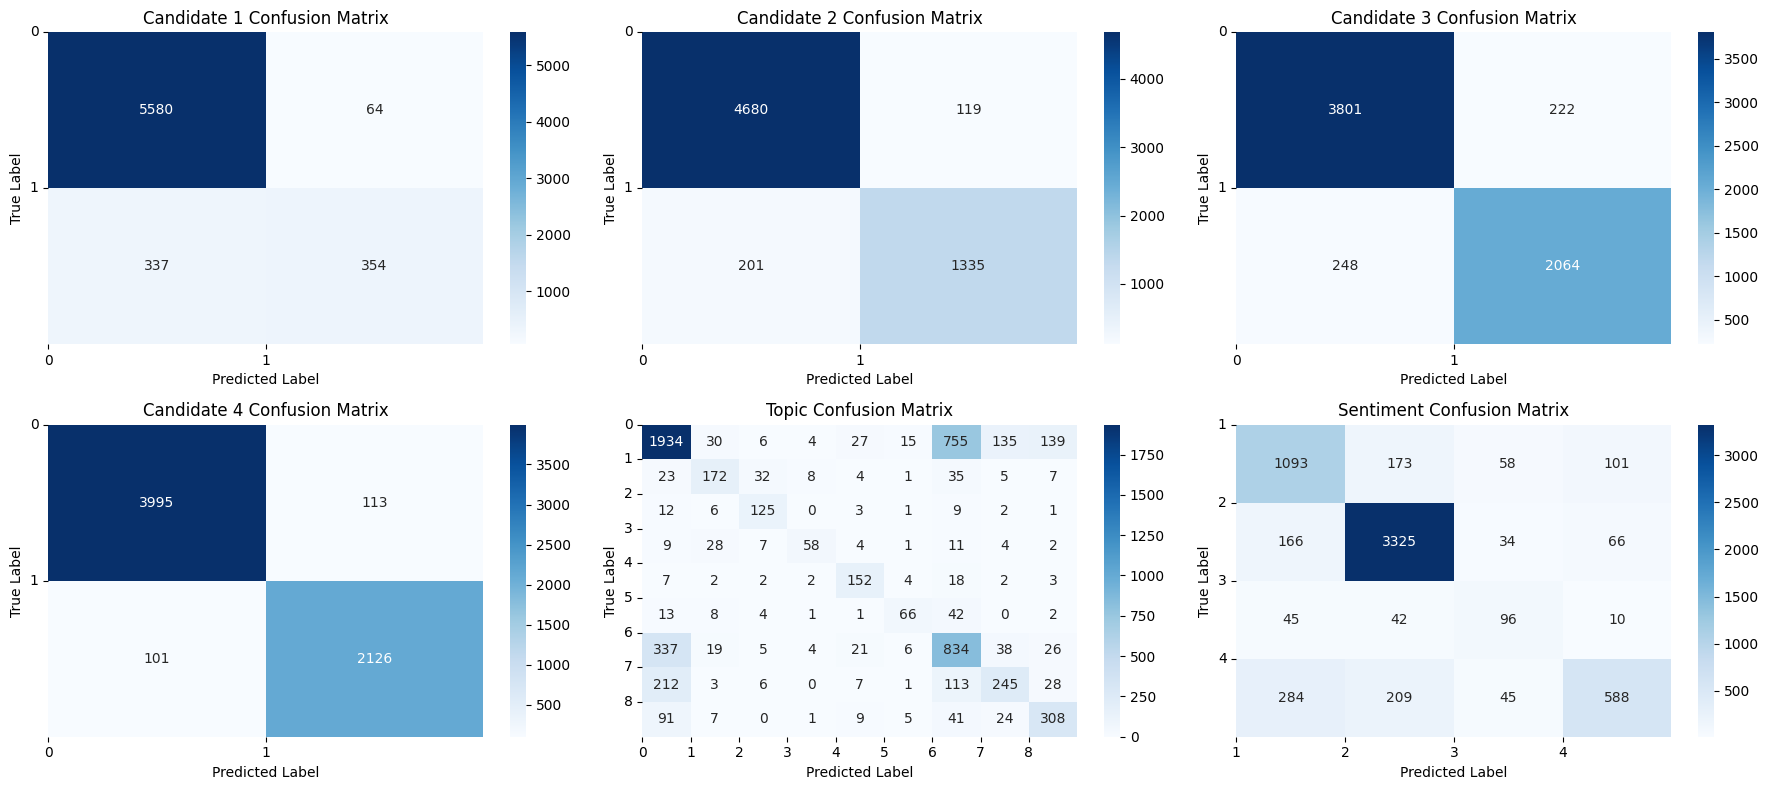

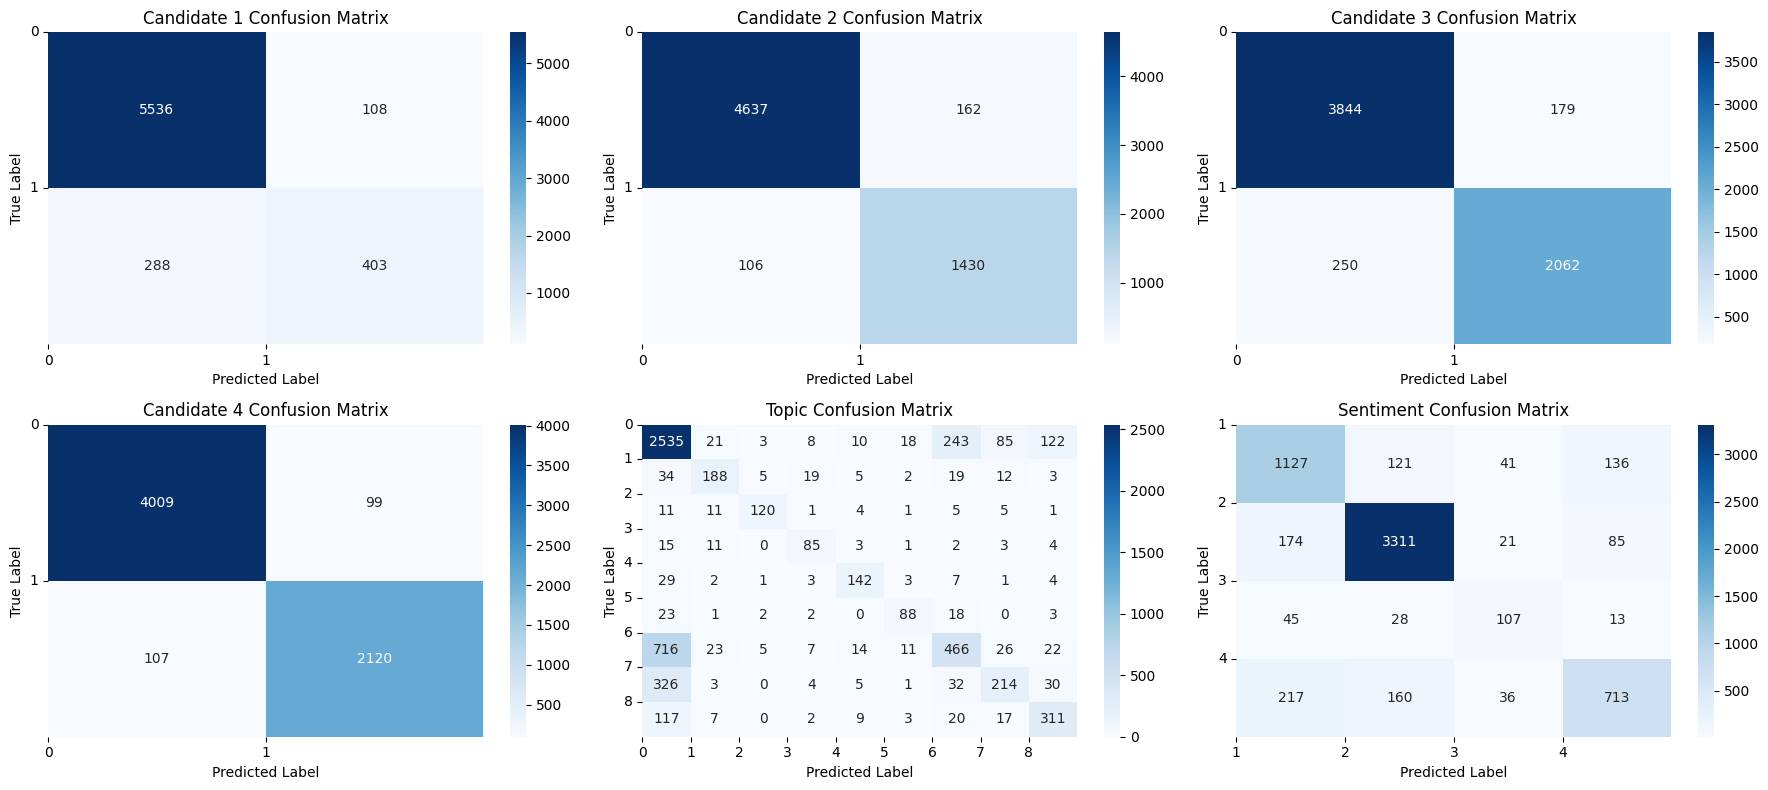

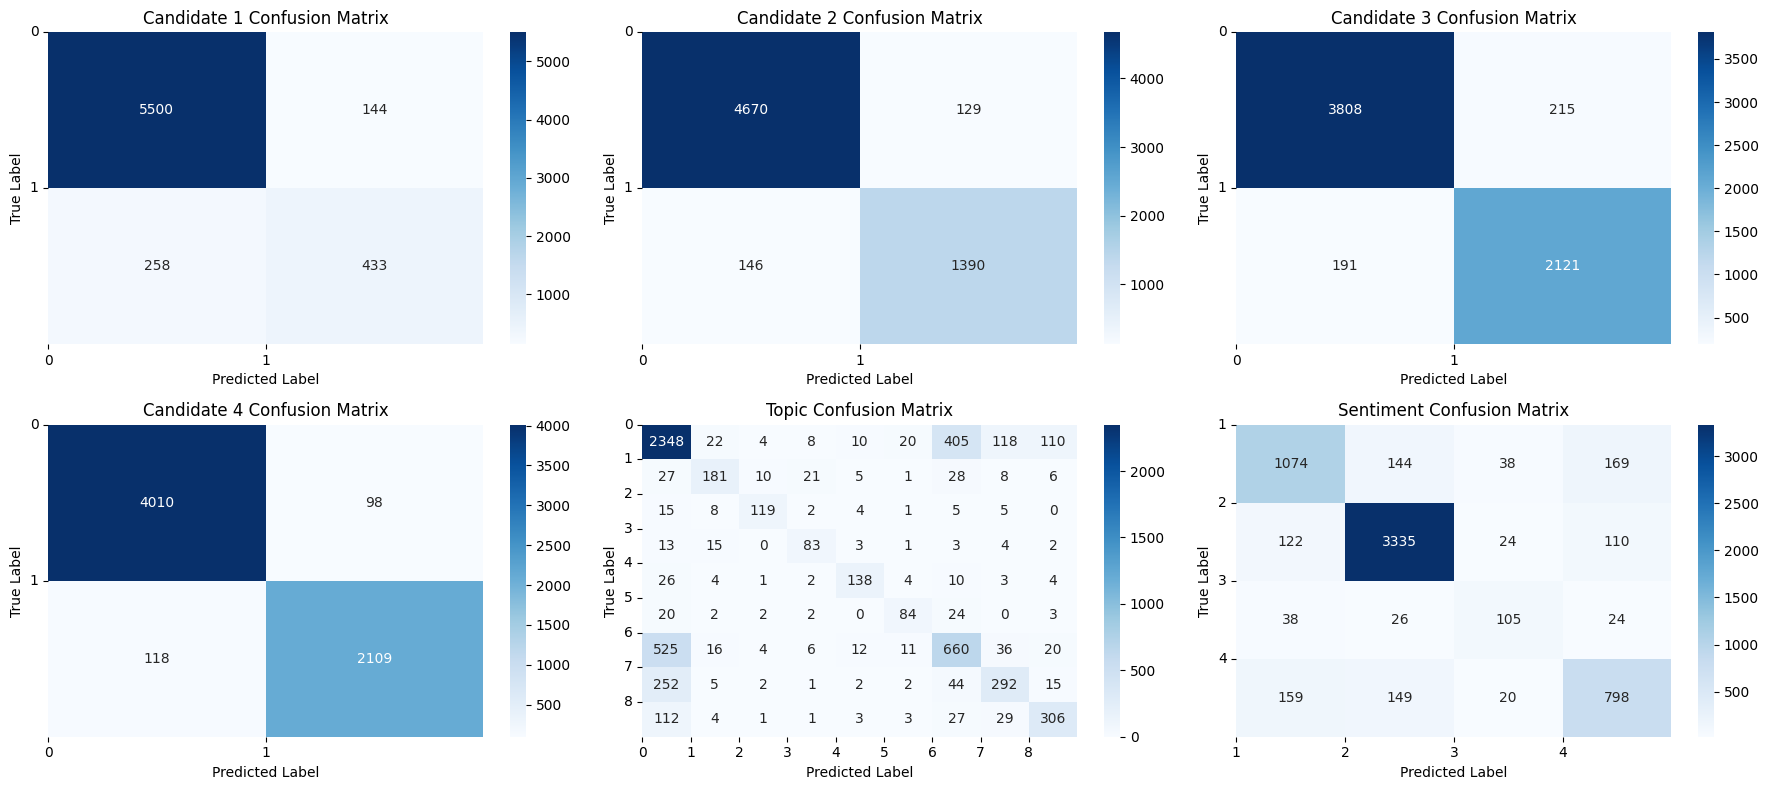

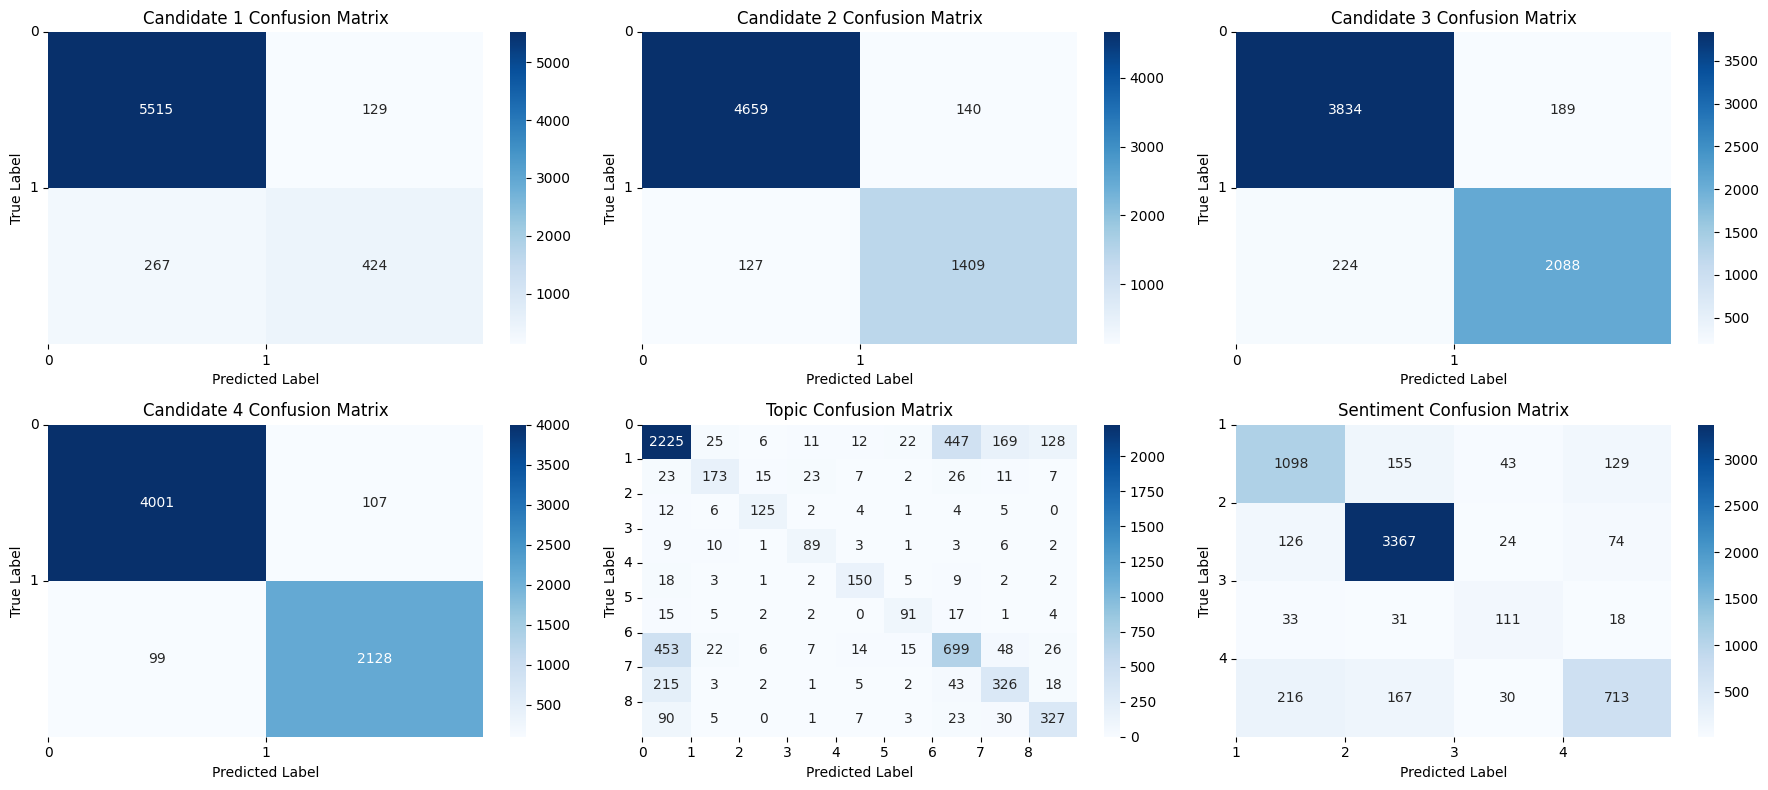

Evaluation Results:
{'eval_loss': 1.8999783992767334, 'eval_candidate_f1': 0.8647396887558447, 'eval_sentiment_accuracy': 0.8348855564325177, 'eval_topic_accuracy': 0.6637726913970008, 'eval_candidate_confusion_matrices': [[[5515, 129], [267, 424]], [[4659, 140], [127, 1409]], [[3834, 189], [224, 2088]], [[4001, 107], [99, 2128]]], 'eval_sentiment_confusion_matrix': [[1098, 155, 43, 129], [126, 3367, 24, 74], [33, 31, 111, 18], [216, 167, 30, 713]], 'eval_topic_confusion_matrix': [[2225, 25, 6, 11, 12, 22, 447, 169, 128], [23, 173, 15, 23, 7, 2, 26, 11, 7], [12, 6, 125, 2, 4, 1, 4, 5, 0], [9, 10, 1, 89, 3, 1, 3, 6, 2], [18, 3, 1, 2, 150, 5, 9, 2, 2], [15, 5, 2, 2, 0, 91, 17, 1, 4], [453, 22, 6, 7, 14, 15, 699, 48, 26], [215, 3, 2, 1, 5, 2, 43, 326, 18], [90, 5, 0, 1, 7, 3, 23, 30, 327]], 'eval_runtime': 124.5822, 'eval_samples_per_second': 50.85, 'eval_steps_per_second': 3.179, 'epoch': 4.0}
candidate_mention: 
    Label 0:
      Precision: 0.7667
      Recall: 0.6136
      F1: 0.6817


In [100]:
metrics = []

train_dataset = CustomDataset(train_df, tokenizer)
val_dataset = CustomDataset(val_df, tokenizer)

# Model 
model = MultiTaskXLMRoberta().to(device) 

# Define output directory for checkpoints and the final model
model_output_dir = "/finetuned_model" 

# Training Arguments
training_args = TrainingArguments(
    output_dir=model_output_dir,
    num_train_epochs=4,             
    per_device_train_batch_size=16,            
    per_device_eval_batch_size=16,
    learning_rate= 1.5e-5,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    fp16=torch.cuda.is_available(),          
    push_to_hub=False,
    report_to='none',
    logging_dir="./logs",
    logging_steps=10
)

# Trainer Initialization
trainer = Trainer(
model=model,
args=training_args,
train_dataset=train_dataset,
eval_dataset=val_dataset,
compute_metrics=compute_metrics, 
callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# Create the ConfusionMatrixCallback after the Trainer is initialized
confusion_matrix_callback = ConfusionMatrixCallback(trainer) 

# Add the confusion matrix callback to the Trainer's callback list 
trainer.add_callback(confusion_matrix_callback)

# Training
try:
    trainer.train()
except Exception as e:
    print(f"Error during training: {e}")

# Evaluate the model 
eval_results = trainer.evaluate()
print("Evaluation Results:")
print(eval_results)

# Get predictions FROM THE BEST MODEL (before saving)
predictions = trainer.predict(val_dataset)

# Extract predictions for each task 
candidate_preds = (torch.sigmoid(torch.tensor(predictions.predictions[0])) > 0.5).int() 
sentiment_preds = np.argmax(predictions.predictions[1], axis=1)
topic_preds = np.argmax(predictions.predictions[2], axis=1)

# Store fold metrics (for each task)
metrics.append({
    'candidate_mention': classification_report(
        predictions.label_ids[:, :4],
        candidate_preds,
        output_dict=True,
        zero_division=0
    ),
    'sentiment': classification_report(
        predictions.label_ids[:, 4],
        sentiment_preds,
        output_dict=True,
        zero_division=0
    ),
    'topic': classification_report(
        predictions.label_ids[:, 5],
        topic_preds,
        output_dict=True,
        zero_division=0
    )
})

# Save the best model
trainer.save_model("best_model")  

for task_metrics in metrics:
    try:
        for task_name, task_results in task_metrics.items():
            print(f"{task_name}: ")
            for label_name in task_results:
                if label_name != 'accuracy' and label_name != 'macro avg' and label_name != 'weighted avg':
                    print(f"    Label {label_name}:")
                    print(f"      Precision: {task_results[label_name]['precision']:.4f}")
                    print(f"      Recall: {task_results[label_name]['recall']:.4f}")
                    print(f"      F1: {task_results[label_name]['f1-score']:.4f}\n")

        print()
    except KeyError as e:
        print(f"KeyError: {e}")
    except TypeError as e:
        print(f"TypeError: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

In [104]:
import torch.onnx

# Access the best model after training
model = trainer.model 
model.eval()  # Set to evaluation mode

from transformers import XLMRobertaTokenizer  # Assuming you're using XLMRoberta
def create_dummy_input(tokenizer, max_length=512):
    """Creates dummy input_ids and attention_mask."""
    dummy_text = "Mas Ganjar Mahfud, semangat untuk terus memperjuangkan kepentingan nasional melalui diplomasi yang cerdas"
    encoding = tokenizer(
        dummy_text,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )
    
    input_ids = encoding['input_ids'].squeeze()
    attention_mask = encoding['attention_mask'].squeeze()

    return input_ids, attention_mask

input_ids, attention_mask = create_dummy_input(tokenizer)

input_ids, attention_mask = create_dummy_input(tokenizer)
input_ids = input_ids.unsqueeze(0).to(device)  # Move to model's device
attention_mask = attention_mask.unsqueeze(0).to(device)

torch.onnx.export(
    model, 
    (input_ids, attention_mask),  # Pass inputs as a tuple
    "roberta_fine_tuned.onnx",
    opset_version=13,
    input_names=["input_ids", "attention_mask"], 
    output_names=["output"]
)